##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 사용자 정의 학습: walkthrough

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

이번 튜토리얼은 붓꽃의 품종을 분류하기 위한 머신러닝 모델을 구축할 것입니다. 다음을 위해 즉시실행[(eager execution)](https://www.tensorflow.org/guide/eager)을 사용합니다.
1. 모델 구축
2. 모델 훈련
3. 예측을 위한 모델 사용

## 텐서플로 프로그래밍

이번 튜토리얼에서는 다음과 같은 고수준 텐서플로의 개념들을 사용합니다.

* [즉시실행(eager execution)](https://www.tensorflow.org/guide/eager) 개발환경,
* [Datasets API](https://www.tensorflow.org/guide/datasets)를 활용한 데이터 불러오기,
* [Keras API](https://keras.io/getting-started/sequential-model-guide/)를 활용한 모델과 layer 구축 .

이번 튜토리얼은 다른 텐서플로 프로그램과 유사하게 구성되어있습니다.

1. 데이터 불러오기 및 분석.
2. 모델 타입 선정.
3. 모델 학습.
4. 모델 효과 검증.
5. 예측을 위한 학습된 모델 사용.

## 프로그램 설정

### 임포트 및 즉시실행 구성

텐서플로를 포함하여 필요한 파이썬 모듈을 임포트하고, 즉시실행을 활성화할 것입니다. 즉시실행은 텐서플로가 나중에 실행되는 [계산 그래프(computational graph)](https://www.tensorflow.org/guide/graphs)를 만드는 대신에 연산을 즉시 평가하고 구체적인 값을 반환하게합니다. 만약 여러분들이 파이썬 대화형 창이나 인터렉티브 콘솔을 사용하시면, 더욱 익숙하실겁니다. 즉시실행은 [Tensorlow >=1.8](https://www.tensorflow.org/install/) 부터 사용가능합니다.

즉시실행이 활성화 될때, 동일한 프로그램내에서는 비활성화를 할 수 없습니다. 더 많은 세부사항은 [즉시실행 가이드](https://www.tensorflow.org/guide/eager)을 참조하세요.

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("텐서플로 버전: {}".format(tf.__version__))
print("즉시실행: {}".format(tf.executing_eagerly()))

텐서플로 버전: 1.10.0
즉시실행: True


## 붓꽃 분류 문제

당신이 식물학자라고 상상하고, 주어진 붓꽃을 자동적으로 분류하는 방법을 찾고있다고 가정합시다. 머신러닝은 통계적으로 꽃을 분류할 수 있는 다양한 알고리즘을 제공합니다. 예를 들어, 정교한 머신러닝 프로그램은 사진을 통해 꽃을 분류할 수 있습니다. 우리의 목적은 좀 더 겸손하게, 측정된 [꽃받침](https://en.wikipedia.org/wiki/Sepal)과 [꽃잎](https://en.wikipedia.org/wiki/Petal)의 길이와 폭을 토대로 붓꽃을 분류하는것입니다.

이 붓꽃은 약 300종 입니다. 하지만 이번 튜토리얼에서는 오직 3가지 품종을 기준으로 분류할 것입니다. 

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>그림 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

다행히도 다른사람들이 먼저 꽃받침과 꽃잎의 길이와 폭이 측정된 [120개의 붓꽃 데이터](https://en.wikipedia.org/wiki/Iris_flower_data_set)를 만들어 놓았습니다. 이것은 머신러닝 분류문제에 있어 초보자들에게 유명한 고전 데이터셋입니다. 

## 훈련 데이터 불러오기 및 분석

데이터를 불러오고 파이썬 프로그램이 사용할 수 있는 구조로 전환합니다.

### 데이터셋 다운로드

[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) 함수를 사용하여 데이터셋을 다운로드합니다. 이 함수는 다운로드된 파일의 경로를 반환합니다.

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: C:\Users\82108\.keras\datasets\iris_training.csv


### 데이터 탐색

이 데이터셋(`iris_training.csv`)은  ','로 구분된 CSV 파일입니다. `head -n5` 명령을 사용하여 처음 5개 항목을 확인합니다. 

In [ ]:
!head -n5 {train_dataset_fp}

처음 5개의 데이터로부터 다음을 주목하세요.

1. 첫번째 줄은 다음과 같은 정보를 포함하고 있는 헤더(header)입니다. 
  * 총 120개의 예가 있으며, 각 예들은 4가지의 특성(feature), 3가지 가능한 레이블(label)을 가지고 있습니다.
2. 후속행은 데이터 레코드입니다. 한 줄당 한가지 *[예](https://developers.google.com/machine-learning/glossary/#example)*입니다.
  * 처음 4개의 필드는 *[특성](https://developers.google.com/machine-learning/glossary/#feature)*입니다.: 이것들은 예제의 특징을 나타냅니다. 이 필드들는 붓꽃의 측정값을 부동소수점으로 나타냅니다.
  * 마지막 컬럼(column)은 *[레이블(label)](https://developers.google.com/machine-learning/glossary/#label)*입니다.: 레이블은 우리가 에측하고자 하는 값을 나타냅니다. 이 데이터셋에서는 꽃의 이름과 관련된 정수값 0, 1, 2를 나타냅니다.

코드로 표현하면 다음과 같습니다.:

In [3]:
# CSV 파일내에서 컬럼의 순서
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


각각의 레이블은 "setosa"와 같은 문자형 이름과 연관되어있습니다. 하지만 머신러닝은 전형적으로 숫자형값에 의존합니다. 레이블을 다음과 같이 맵핑(mapping) 합니다. 

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

특성과 레이블에 관한 더 많은 정보를 위해서는 다음을 참조하세요. [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

In [4]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### `tf.data.Dataset` 생성

텐서플로의 [Dataset API](https://www.tensorflow.org/guide/datasets)는 데이터를 모델에 적재하기 위한 많은 케이스를 다룹니다. 이는 훈련을 위한 형태로 데이터를 읽고 변환하는 고수준 API입니다. 더 많은 정보를 위해서는 다음을 참조하세요. [Datasets Quick Start guide](https://www.tensorflow.org/get_started/datasets_quickstart) 


데이터셋이 CSV 형태의 파일이므로, 적절한 형태로 데이터를 구분하기위해 [make_csv_dataset](https://www.tensorflow.org/api_docs/python/tf/contrib/data/make_csv_dataset) 함수를 사용하겠습니다. 이 함수는 훈련모델을 위한 데이터를 생성하므로, 초기값은 셔플(`shuffle=True, shuffle_buffer_size=10000`)과 무한반복(`num_epochs=None`)으로 설정되어있습니다. 또한 [배치 사이즈(batch_size)](https://developers.google.com/machine-learning/glossary/#batch_size)를 설정해줍니다.

In [5]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

`make_csv_dataset` 함수는 `tf.data.Dataset` 의 `(features, label)` 쌍을 반환합니다. `features`는 사전형 객체인: `{'feature_name': value}`로 주어집니다.
또한 즉시실행 활성화로 이 `Dataset`은 반복가능합니다. 다음은 특성(feature)들을 살펴봅시다.

In [6]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=60, shape=(32,), dtype=float32, numpy=
              array([4.4, 4.5, 5. , 4.8, 6. , 6.3, 4.6, 5. , 5.6, 5.1, 6.4, 5.8, 6.7,
                     5.7, 6.5, 7.7, 5.1, 4.8, 6.1, 5.8, 7.2, 6.8, 6. , 4.9, 6.3, 6.4,
                     6.7, 5.3, 6.7, 5. , 7.2, 7.7], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=61, shape=(32,), dtype=float32, numpy=
              array([2.9, 2.3, 3. , 3. , 2.9, 2.7, 3.4, 3.5, 2.5, 3.8, 3.2, 4. , 3. ,
                     2.8, 3. , 2.6, 3.8, 3.1, 2.8, 2.8, 3.2, 3. , 2.2, 3.1, 2.3, 2.8,
                     3.1, 3.7, 3. , 3.4, 3. , 3. ], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=58, shape=(32,), dtype=float32, numpy=
              array([1.4, 1.3, 1.6, 1.4, 4.5, 4.9, 1.4, 1.3, 3.9, 1.6, 5.3, 1.2, 5. ,
                     4.1, 5.8, 6.9, 1.9, 1.6, 4. , 5.1, 6. , 5.5, 5. , 1.5, 4.4, 5.6,
                     5.6, 1.5, 5.2, 1.6, 5.8, 6.1],

유사한 특성의 값들은 같이 그룹되어있거나, *배치* 되있다는 사실에 주목하세요. 각 예제행의 필드는 해당 특성 배열에 추가됩니다. `batch_size` 조절하여 이 특성 배열에 저장된 예제의 수를 설정하세요.

또한 여러분들은 배치(batch)로부터 약간의 특성을 도식화하여 군집되있는 데이터를 확인할 수 있습니다. 

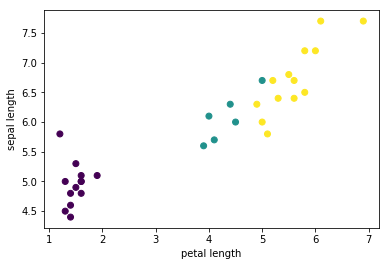

In [10]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("petal length")
plt.ylabel("sepal length");

모델 구축단계를 단순화하기 위해서, 특성(사전형 객체)을 `(batch_size, num_features)`의 형태를 가지는 단일 배열로 다시 구성하는 함수를 생성합니다.

이 함수는 `Tensor`의 list로부터 값을 취하고 특정한 차원으로 결합된 `Tensor`를 생성하는 [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) 메서드(method)를 사용합니다.

In [11]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

그 후 각 `(features,label)`쌍의 `features`을 훈련 데이터셋에 적재하기위해 [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) 메서드를 사용합니다. 

In [12]:
train_dataset = train_dataset.map(pack_features_vector)

데이터셋의 특성 요소들은 이제 형태가 `(batch_size, num_features)`인 배열입니다. 첫 5행의 예제를 살펴봅시다.

In [13]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[4.9 3.  1.4 0.2]
 [6.6 2.9 4.6 1.3]
 [6.8 3.2 5.9 2.3]
 [5.  3.5 1.3 0.3]
 [7.7 2.8 6.7 2. ]], shape=(5, 4), dtype=float32)


## 모델 타입 선정

### 왜 모델을 사용해야하는가?

 *[모델](https://developers.google.com/machine-learning/crash-course/glossary#model)*은 특성(feature)들과 레이블(label)과의 관계입니다. 붓꽃 분류 문제에서 모델은 측정된 꽃받침과 꽃잎 사이의 관계를 정의하고 붓꽃의 품종을 예측합니다. 몇가지 간단한 모델은 몇 줄의 대수학으로 표현할 수 있으나, 복잡한 머신러닝 모델은 요약하기 힘든 굉장히 많은 수의 매개변수를 가지고 있습니다.

머신러닝을 사용하지 않고 4가지의 특성 사이의 관계를 결정하고 붓꽃을 품종을 예측하실 수 있으신가요? 즉, 여러분들이 특정 품종의 꽃받침과 꽃잎과의 관계를 정의할 수 있을정도로 데이터셋을 분석했다면, 전통적인 프로그래밍 기술(예를 들어 굉장히 많은 조건문들)을 사용하여 모델은 만들 수 있으신가요? 더 복잡한 데이터셋에서 이는 불가능에 가까울 수 있습니다. 잘 구성된 머신러닝은 여러분들을 위한 모델을 결정합니다. 만약 여러분들이 충분한 예제를 잘 구성된 머신러닝 모델에 제공한다면, 프로그램은 여러분들을 위한 특성들 사이의 관계를 이해하고 제공합니다. 

### 모델 선정

우리는 학습을 위한 모델의 종류를 선정해야합니다. 여러정류의 모델이 있고, 이를 선택하는 것은 많은 경험이 필요합니다. 이번 튜토리얼에서는 붓꽃 분류 문제를 해결하기위해 *[신경망(neural network)](https://developers.google.com/machine-learning/glossary/#neural_network)* 모델을 사용하겠습니다. 신경망 모델은 특성과 레이블 사이의 복잡한 관계를 찾을 수 있습니다. 신경망은 하나 또는 그 이상의 *[은닉층(hidden layer)](https://developers.google.com/machine-learning/glossary/#hidden_layer)*들로 구성된 그래프입니다. 각각의 은닉층은 하나 이상의 *[뉴런(neuron)](https://developers.google.com/machine-learning/glossary/#neuron)*으로 구성되어있습니다. 몇가지 신경망의 범주가 있으며, 이번 튜토리얼에서는 *[dense(또는 fully-connected neural network)](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*를 사용합니다: 완전연결 신경망(fully-connected neural network)은 하나의 뉴런에 이전층의 모든 뉴런의 입력을 받는 신경망입니다. 예를 들어, `그림 2`는 입력층, 2개의 은닉층, 그리고 출력층으로 구성된 완전연결 신경망입니다. 

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>그림 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

그림 2의 모델이 훈련되고 레이블 되어있지 않은 데이터를 제공했을때, 모델은 주어진 데이터의 3가지 예측을 출력(주어진 레이블의 개수)합니다. 이러한 예측은 *[추론(inference)](https://developers.google.com/machine-learning/crash-course/glossary#inference)*이라고 정의합니다. 이 예제에서 출력의 합은 1.0입니다. 그림 2에서 예측은 *Iris setosa* `0.02`, *Iris versicolor* `0.95`, *Iris virginica*에 `0.03`로 주어집니다. 이는 모델이 95%의 확률로 주어진 데이터를 *Iris versicolor*로 예측한다는 것을 의미합니다. 

### Keras를 사용한 모델 생성

텐서플로의 [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API는 모델과 layer를 생성하기위한 풍부한 라이브러리를 제공합니다. 이는 연결되있는 모든것들을 케라스가 처리하여 모델을 구축하기 쉽게 만듭니다.

[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)은 layer의 선형 적층 모델입니다. 이 구조는 layer의 인스턴스를 취하며, 아래의 케이스의 경우 각 layer당 10개의 노드(node)를 가지는 2개의 [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)층과 3개의 예측(레이블의 개수)노드를 가지는 출력 층으로 구성되어있습니다. 첫번째 layer의 `input_shape` 매개변수는 데이터셋의 특성의 수와 관계있습니다.

In [15]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

*[활성화 함수(activation function)](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)*는 각 층들의 출력의 형태를 결정합니다. 이러한 비선형성은 중요하며, 활성화 함수가 없는 모델은 단일층과 동일하다고 생각할 수 있습니다. 사용가능한 [활성화 함수](https://www.tensorflow.org/api_docs/python/tf/keras/activations)는 많지만, [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU)가 은닉층에 주로 사용됩니다. 

이상적인 은닉층과 뉴런의 개수는 문제와 데이터셋에 좌우됩니다. 머신러닝의 여러측면과 마찬가지로, 신경망의 최적의 형태를 결정하는것은 많은 경험과 지식이 필요합니다. 경험을 토대로, 은닉층과 뉴런의 증가는 전형적으로 강력한 모델을 생성하므로, 모델을 효과적으로 훈련시키기 위해서 더 많은 데이터를 필요로 합니다.

### 모델 사용

이 모델이 배치 특성에 대해 수행하는 작업을 간단히 살펴보겠습니다. 

In [16]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=194, shape=(5, 3), dtype=float32, numpy=
array([[-0.5606402 ,  0.07388121,  1.7559104 ],
       [-0.81253123,  0.15423062,  2.618011  ],
       [-0.8249443 ,  0.17057645,  2.878077  ],
       [-0.5900409 ,  0.05973166,  1.8200195 ],
       [-0.9059934 ,  0.2684719 ,  3.2923307 ]], dtype=float32)>

각 예제는 각 클래스에 대한 [로짓(logit)](https://developers.google.com/machine-learning/crash-course/glossary#logits)을 반환합니다. 

이 로짓(logit)을 각 클래스에 대한 확률로 변환하기 위하서 [소프트맥스(softmax)](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 함수를 사용하겠습니다.

In [17]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=200, shape=(5, 3), dtype=float32, numpy=
array([[0.07676508, 0.14478812, 0.7784468 ],
       [0.02896636, 0.07616462, 0.894869  ],
       [0.02258569, 0.06111989, 0.91629446],
       [0.07117569, 0.13630895, 0.7925153 ],
       [0.01412208, 0.04570488, 0.940173  ]], dtype=float32)>

`tf.argmax`는 예측된 값들 중 가장 큰 확률(우리가 원하는 클래스)을 반환합니다. 하지만 모델이 아직 훈련되지 않았으므로 이는 좋은 예측이 아닙니다.

In [18]:
print("예측: {}".format(tf.argmax(predictions, axis=1)))
print("    레이블: {}".format(labels))

예측: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    레이블: [0 1 2 0 2 1 0 0 2 1 1 2 2 2 0 2 0 2 0 2 0 0 1 0 0 1 2 2 2 1 0 2]


## 모델 훈련하기

*[훈련 단계](https://developers.google.com/machine-learning/crash-course/glossary#training)*는 모델이 점진적으로 최적화되거나 데이터셋을 학습하는 머신러닝의 과정입니다. 훈련의 목적은 미지의 데이터를 예측하기 위해, 훈련 데이터셋의 구조에 대해서 충분히 학습하는 것입니다. 만약 모델이 훈련 데이터셋에 대해서 과하게 학습된다면 오직 훈련 데이터셋에 대해서 작동할 것이며, 일반화되기 힘들 것입니다. 이러한 문제를 *[과대적합(overfitting)](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)* 이라고 합니다. 이는 마치 문제를 이해하고 해결한다기보다는 답을 기억하는 것이라고 생각할 수 있습니다. 

붓꽃 분류 문제는 지도학습 *[지도학습(supervised machine learning)](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*의 예시 중 하나입니다.: 지도학습은 모델이 레이블을 포함한 훈련 데이터로부터 학습됩니다. *[비지도학습(unsupervised machine learning)](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)*에서는 훈련 데이터가 레이블을 포함하고 있지않습니다. 대신에 모델은 특성들의 패턴을 찾습니다. 

### 손실 함수와 그래디언트 함수 정의하기

훈련과 평가단계는 모델의 *[손실(loss)](https://developers.google.com/machine-learning/crash-course/glossary#loss)* 계산할 필요가 있습니다. 손실은 모델의 예측이 원하는 레이블과 얼마나 일치하는지, 또한 모델이 잘 작동하는지에 대한 척도로 사용됩니다. 우리는 이 값은 최소화하고, 최적화하기를 원합니다. 

모델의 손실은 [tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy) 함수를 사용하여 계산할 것입니다. 이 함수는 모델의 클래스(레이블)과 예측된 값(로짓)을 입력받아 예제를 통한 평균 손실을 반환합니다.

In [21]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("손실 테스트: {}".format(l))

손실 테스트: 1.5565308332443237


모델을 최적화하기 위해 사용되는 *[그래디언트(gradient)](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* 계산하기위해 [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 컨텍스트를 사용합니다. 더 자세한 정보는 [즉시실행 가이드](https://www.tensorflow.org/guide/eager)를 확인하세요. 

In [22]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### 옵티마이저(Optimizer) 생성 

*[옵티마이저(optimizer)](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)*는 `손실`함수를 최소화하기위해 계산된 그래디언트를 모델의 변수에 적용합니다. 손실함수를 구부러진 곡선의 표면(그림 3)으로 생각할 수 있으며, 우리는 이 함수의 최저점을 찾고자합니다. 그래디언트는 가장 가파른 상승방향을 가르키며 따라서 우리는 반대방향으로 이동하는 여행을 합니다.각 배치마다의 손실과 기울기를 반복적으로 계산하여 훈련 중에 모델을 조정합니다. 점진적으로, 모델은 손실을 최소화하기위해 가중치(weight)와 편향(bias)의 최적의 조합을 찾아냅니다. 더 적은 손실을 통해 더 좋은 모델의 예측을 기대할 수 있습니다. 

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b> 그림 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

텐서플로는 학습을 위해 이용 가능한 여러종류의 [최적화 알고리즘](https://www.tensorflow.org/api_guides/python/train)을 가지고 있습니다. 이번 모델에서는 *[확률적 그래디언트 하강(stochastic gradient descent, SGD)](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* 을 구현하는 [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)를 사용하겠습니다. 매개변수 `learning_rate`은 경사하강 과정의 크기를 나타내는 척도이며, 더 나은 결과를 위해 공동적으로 조절가능한 *하이퍼파라미터(hyperparameter)* 입니다. 

옵티마이저(optimizer)와 `global_step`을 설정합니다.

In [25]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.contrib.eager.Variable(0)

이 값들을 단일 최적화 단계를 계산하기위해 사용합니다. 

In [26]:
loss_value, grads = grad(model, features, labels)

print("단계: {}, 초기 손실: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("단계: {},         손실: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

단계: 0, 초기 손실: 1.5565308332443237
단계: 1,         손실: 1.4113397598266602


### 훈련 루프

모든 조각을 가지고, 모델은 학습할 준비가 되었습니다! 훈련 루프는 더 나은 예측을 위해 데이터셋을 모델로 제공합니다. 다음의 코드 블럭은 아래의 훈련 단계를 작성한 것입니다. 

1. 각 *에포크(epoch)* 반복. 에포크는 데이터셋을 통과시키는 횟수입니다. 
2. 에포크내에서, `Dataset`의 *features* (`x`)와 *label* (`y`)를 가져오는 예제를 반복합니다.
3. 예제의 특성을 사용하여 결과를 예측을 하고 레이블과 비교합니다. 예측의 부정확도를 측정하고 모델의 손실과 그래디언트를 계산하기위해 사용합니다. 
4. 모델의 변수를 업데이트하기위해 `옵티마이저(optimizer)`를 사용합니다. 
5. 시각화를 위해 몇가지 값을 추적합니다.
6. 각 에포크를 반복합니다.

`num_epochs` 변수는 데이터셋 반복 횟수입니다. 반직관적으로, 모델을 길게 학습하는것이 더 나은 모델이 될 것이라고 보장하지 못합니다. `num_epochs`는 여러분들이 조정가능한 *[하이퍼파라미터(hyperparameter)](https://developers.google.com/machine-learning/glossary/#hyperparameter)* 입니다. 적절한 횟수를 선택하는것은 경험과 직관을 필요로 합니다. 

In [27]:
## Note: 이 셀을 다시 실행하면 동일한 모델의 변수가 사용됩니다.

from tensorflow import contrib
tfe = contrib.eager

# 도식화를 위해 결과 저장
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # 훈련 루프 - 32번의 배치 실행
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)

    # 진행 상황 추적
    epoch_loss_avg(loss_value)  # 현재 배치의 손실 추가
    # 예측된 레이블과 실제 레이블 비교
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # epoch 종료
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("에포크 {:03d}: 손실: {:.3f}, 정확도: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

에포크 000: 손실: 1.364, 정확도: 35.000%
에포크 050: 손실: 0.732, 정확도: 70.833%
에포크 100: 손실: 0.434, 정확도: 95.000%
에포크 150: 손실: 0.273, 정확도: 98.333%
에포크 200: 손실: 0.231, 정확도: 99.167%


### 시간에 따른 손실함수 시각화

모델의 훈련 과정을 출력하는 것은 도움이 되지만, 훈련 과정을 직접 보는 것이 더 도움이 되곤합니다. [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard)는 텐서플로에 패키지되어있는 굉장히 유용한 시각화 툴입니다. 하지만 우리는 `matplotlib` 모듈을 사용하여 일반적인 차트를 출력할 수 있습니다.

이 차트를 해석하는것은 여러 경험이 필요하지만, 우리는 *손실*이 내려가고 *정확도*가 올라가는 것을 보고싶습니다.

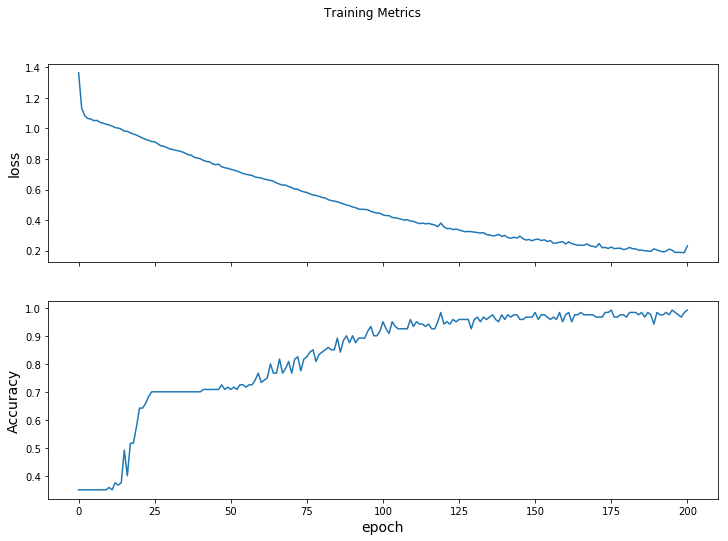

In [29]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

## 모델 유효성 검증

이제 모델은 학습되었습니다. 우리는 모델의 성능을 검증하기위해 몇가지 통계를 얻을 수 있습니다. 

*평가(Evaluating)*는 모델이 예측을 얼마나 효과적으로 수행하는지 결정하는것을 의미합니다. 붓꽃 분류 모델의 유효성을 결정하기 위해서, 몇가지 꽃잎과 꽃받침 데이터를 통과시키고 어떠한 품종을 예측하는지 확인합니다. 그 후 실제 품종과 비교합니다. 예를 들어, 절반의 데이터를 올바르게 예측한 모델의 *[정확도](https://developers.google.com/machine-learning/glossary/#accuracy)* 는 `0.5`입니다. 그림 4는 조금 더 효과적인 보여줍니다. 5개의 예측 중 4개를 올바르게 예측한 80% 정확도의 모델입니다.

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>그림 4.</b> An Iris classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### 테스트 데이터셋 설정

모델을 평가하는것은 모델을 학습하는것과 유사합니다. 가장 큰 차이는 훈련 데이터가 아닌 *[테스트 데이터셋](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* 을 사용했다는 것입니다. 공정하게 모델의 유효성을 평가하기위해, 모델을 평가하기위한 예제는 반드시 훈련 데이터와 달라야합니다. 

테스트 데이터셋을 설정하는것은 훈련 데이터셋을 설정하는 것과 유사합니다. CSV 파일을 다운로드하고 값을 구분합니다. 그 후 약간의 셔플을 적용합니다.

In [ ]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [ ]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### 테스트 데이터셋을 사용한 모델 평가

훈련 단계와는 다르게 모델은 테스트 데이터에 대해서 오직 한번의 [epoch](https://developers.google.com/machine-learning/glossary/#epoch)을 진행합니다. 다음의 코드셀은 테스트 셋을 반복하여 실행하고 실제 레이블과 비교합니다. 이는 전체 테스트 데이터셋에 대한 정확도를 측정하는데 사용됩니다.

In [ ]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("테스트셋 정확도: {:.3%}".format(test_accuracy.result()))

예를들어, 마지막 배치에서 모델이 일반적으로 정확하다는 것을 확인할 수 있습니다. 

In [ ]:
tf.stack([y,prediction],axis=1)

## 예측을 위해 훈련된 모델 사용하기

우리는 이제 붓꽃을 분류하기위해 완벽하지는 않지만 어느정도 검증된 모델을 가지고 있습니다. 훈련된 모델을 사용하여 [레이블 되지 않은 데이터](https://developers.google.com/machine-learning/glossary/#unlabeled_example)들을 예측해봅시다.

실제로는 레이블되지 않은 예제들은 여러 소스(앱, CSV 파일, 직접제공 등)로 부터 제공될 수 있습니다. 지금은 레이블을 예측하기위해 수동으로 3개의 레이블되지 않은 예제를 제공하겠습니다.  레이블은 다음과 붓꽃이름으로 맵핑되어있습니다.
* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [ ]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("예 {} 예측: {} ({:4.1f}%)".format(i, name, 100*p))